In [26]:
import pandas as pd
import json
import os
import sys
import re
import time
import requests

# pandas dataframe display configuration
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

YOUTUBE_COMMENTS_AJAX_URL = 'https://www.youtube.com/comment_service_ajax'

USER_AGENT = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36'
# csv file name
FILE_NAME = 'ytb_comments.csv'

# set parameters
# filter comments by popularity or recent, 0:False, 1:True
SORT_BY_POPULAR = 1
# default recent
SORT_BY_RECENT = 1
# set comment limit
COMMENT_LIMIT = 200

YT_CFG_RE = r'ytcfg\.set\s*\(\s*({.+?})\s*\)\s*;'
YT_INITIAL_DATA_RE = r'(?:window\s*\[\s*["\']ytInitialData["\']\s*\]|ytInitialData)\s*=\s*({.+?})\s*;\s*(?:var\s+meta|</script|\n)'

def regex_search(text, pattern, group=1, default=None):
    match = re.search(pattern, text)
    return match.group(group) if match else default

def ajax_request(session, endpoint, ytcfg, retries=5, sleep=20):
    url = 'https://www.youtube.com' + endpoint['commandMetadata']['webCommandMetadata']['apiUrl']

    data = {'context': ytcfg['INNERTUBE_CONTEXT'],
            'continuation': endpoint['continuationCommand']['token']}

    for _ in range(retries):
        response = session.post(url, params={'key': ytcfg['INNERTUBE_API_KEY']}, json=data)
        if response.status_code == 200:
            return response.json()
        if response.status_code in [403, 413]:
            return {}
        else:
            time.sleep(sleep)

def download_comments(YOUTUBE_VIDEO_URL, sort_by=SORT_BY_RECENT, language=None, sleep=0.1):
    session = requests.Session()
    session.headers['User-Agent'] = USER_AGENT
    response = session.get(YOUTUBE_VIDEO_URL)

    if 'uxe=' in response.request.url:
        session.cookies.set('CONSENT', 'YES+cb', domain='.youtube.com')
        response = session.get(YOUTUBE_VIDEO_URL)

    html = response.text
    ytcfg = json.loads(regex_search(html, YT_CFG_RE, default=''))
    if not ytcfg:
        return  # Unable to extract configuration
    if language:
        ytcfg['INNERTUBE_CONTEXT']['client']['hl'] = language

    data = json.loads(regex_search(html, YT_INITIAL_DATA_RE, default=''))

    section = next(search_dict(data, 'itemSectionRenderer'), None)
    renderer = next(search_dict(section, 'continuationItemRenderer'), None) if section else None
    if not renderer:
        # Comments disabled?
        return

    needs_sorting = sort_by != SORT_BY_POPULAR
    continuations = [renderer['continuationEndpoint']]
    while continuations:
        continuation = continuations.pop()
        response = ajax_request(session, continuation, ytcfg)

        if not response:
            break
        if list(search_dict(response, 'externalErrorMessage')):
            raise RuntimeError('Error returned from server: ' + next(search_dict(response, 'externalErrorMessage')))

        if needs_sorting:
            sort_menu = next(search_dict(response, 'sortFilterSubMenuRenderer'), {}).get('subMenuItems', [])
            if sort_by < len(sort_menu):
                continuations = [sort_menu[sort_by]['serviceEndpoint']]
                needs_sorting = False
                continue
            raise RuntimeError('Failed to set sorting')

        actions = list(search_dict(response, 'reloadContinuationItemsCommand')) + \
                  list(search_dict(response, 'appendContinuationItemsAction'))
        for action in actions:
            for item in action.get('continuationItems', []):
                if action['targetId'] == 'comments-section':
                    # Process continuations for comments and replies.
                    continuations[:0] = [ep for ep in search_dict(item, 'continuationEndpoint')]
                if action['targetId'].startswith('comment-replies-item') and 'continuationItemRenderer' in item:
                    # Process the 'Show more replies' button
                    continuations.append(next(search_dict(item, 'buttonRenderer'))['command'])

        for comment in reversed(list(search_dict(response, 'commentRenderer'))):
            yield {'cid': comment['commentId'],
                   'text': ''.join([c['text'] for c in comment['contentText'].get('runs', [])]),
                   'time': comment['publishedTimeText']['runs'][0]['text'],
                   'author': comment.get('authorText', {}).get('simpleText', ''),
                   'channel': comment['authorEndpoint']['browseEndpoint'].get('browseId', ''),
                   'votes': comment.get('voteCount', {}).get('simpleText', '0'),
                   'photo': comment['authorThumbnail']['thumbnails'][-1]['url'],
                   'heart': next(search_dict(comment, 'isHearted'), False)}

        time.sleep(sleep)


def search_dict(partial, search_key):
    stack = [partial]
    while stack:
        current_item = stack.pop()
        if isinstance(current_item, dict):
            for key, value in current_item.items():
                if key == search_key:
                    yield value
                else:
                    stack.append(value)
        elif isinstance(current_item, list):
            for value in current_item:
                stack.append(value)


def main(url):
    df_comment = pd.DataFrame()
    try:
        youtube_url = url
        limit = COMMENT_LIMIT

        print('Downloading Youtube comments for video:', youtube_url)

        count = 0

        start_time = time.time()

        for comment in download_comments(youtube_url):

            df_comment = df_comment.append(comment, ignore_index=True)

            # comments overview
            comment_json = json.dumps(comment, ensure_ascii=False)
            print(comment_json)

            count += 1

            if limit and count >= limit:
                break

        print("DataFrame Shape: ", df_comment.shape, "\nComment DataFrame: ", df_comment)

        if not os.path.isfile(FILE_NAME):
            df_comment.to_csv(FILE_NAME, encoding='utf-8', index=False)
        else:  # else it exists so append without writing the header
            df_comment.to_csv(FILE_NAME, mode='a', encoding='utf-8', index=False, header=False)

        print('\n[{:.2f} seconds] Done!'.format(time.time() - start_time))

    except Exception as e:
        print('Error:', str(e))
        sys.exit(1)

    # dumping youtube comments
youtube_URL = 'https://www.youtube.com/watch?v=kXvOwXbdhPY'
main(youtube_URL)

{"cid": "UgyRGrpbuhfIaQbhVXp4AaABAg", "text": "Half of your problems will be gone just by listening to her, so much of positive vibes in her voice.  Thank you mataji 🙏", "time": "11 months ago (edited)", "author": "Nikhil Sharma", "channel": "UCwUTTWK-88I7P0b10crWwxg", "votes": "568", "photo": "https://yt3.ggpht.com/ytc/AKedOLQw-RSZRypUoplKIJvaN_I30eSMOc7tpxVC12y81w=s176-c-k-c0x00ffffff-no-rj", "heart": false}
{"cid": "UgyU3QKYxuIB99XJTGB4AaABAg", "text": "1:08 Dry Ginger , Black Pepper , Pan and Tulsi\n2:23 Ginger Juice , Honey and Haldi\n2:55 Jaggery , Ginger Powder and Turmeric (laddu)\n3:44 Salt Water Gargling\n4:20 Use of Warm Water", "time": "11 months ago (edited)", "author": "Smit 07", "channel": "UCC0i07MlqNOUpE8rY1QzQqg", "votes": "1.2K", "photo": "https://yt3.ggpht.com/ytc/AKedOLQFZsMWbkc1v7c7Z1gvLFFseDKDHQkJHn8e3g=s176-c-k-c0x00ffffff-no-rj", "heart": false}
{"cid": "Ugw5Z25r9OK-xZwPMKN4AaABAg", "text": "You seem like you're the best and most caring grandma and mother ever😇

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



DataFrame Shape:  (20, 8) 
Comment DataFrame:                            author                   channel                         cid  heart                                              photo                                               text                    time votes
0                  Nikhil Sharma  UCwUTTWK-88I7P0b10crWwxg  UgyRGrpbuhfIaQbhVXp4AaABAg    0.0  https://yt3.ggpht.com/ytc/AKedOLQw-RSZRypUoplK...  Half of your problems will be gone just by lis...  11 months ago (edited)   568
1                        Smit 07  UCC0i07MlqNOUpE8rY1QzQqg  UgyU3QKYxuIB99XJTGB4AaABAg    0.0  https://yt3.ggpht.com/ytc/AKedOLQFZsMWbkc1v7c7...  1:08 Dry Ginger , Black Pepper , Pan and Tulsi...  11 months ago (edited)  1.2K
2                      Aqua Blue  UChJxqOvNjJLVw1L4-_HoeMg  Ugw5Z25r9OK-xZwPMKN4AaABAg    0.0  https://yt3.ggpht.com/ytc/AKedOLTOUkMrRQBP_xyW...  You seem like you're the best and most caring ...            8 months ago   191
3              Mishu ki duniya 🌸  UC6KXg5rp3ug2mz

TypeError: object of type 'NoneType' has no len()

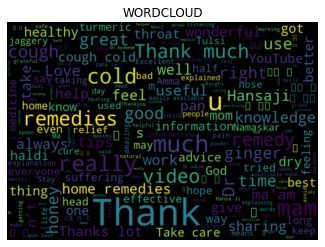

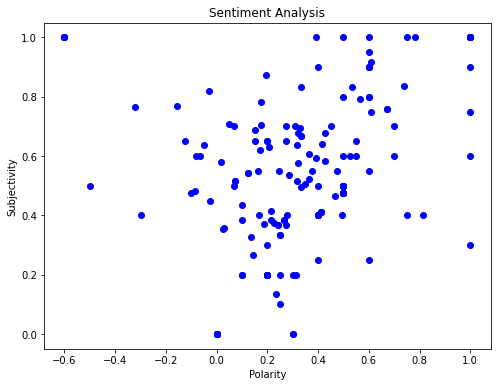

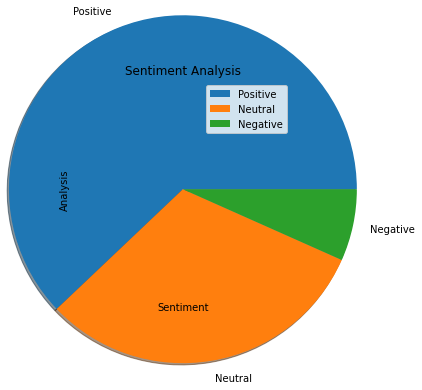

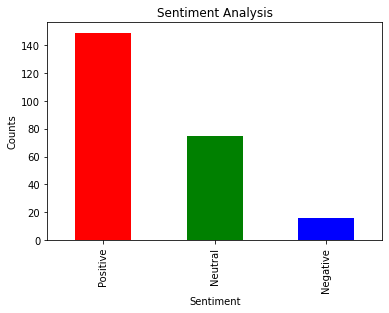

RECOMMENDATION ON THE BASIS OF ANALYSIS
POSITIVE COMMENTS PERCENTAGE:  62.1
NEGATIVE COMMENTS PERCENTAGE:  6.7
NEUTRAL COMMENTS PERCENTAGE:  31.2
According to the Analysis:
The Percentage of Positive reviews is higher.
So, We recommend you to watch the video.


In [23]:
from textblob import TextBlob
import pandas as pd
import re
import matplotlib.pyplot as plt

import os
os.chdir("E:\B.Tech\PROJECTS\Project2\youtube-comment-scraper-main")

data = pd.read_csv("ytb_comments.csv")
log=data.drop(['cid','channel','heart','photo'], axis = 1)

df=pd.DataFrame(data=log['text'])
df.head()

def cleanTxt(txt):
    txt=re.sub(r'@[A-Za-z0-9]+','',txt)
    txt=re.sub(r'#','',txt)
    return txt

df['text']=df['text'].apply(cleanTxt)

df

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize

# print(stopwords.words('english'))

stop_words = set(stopwords.words('english'))

df['text'] = df['text'].str.strip()

def remove_stopwords(line):
    word_tokens = word_tokenize(line)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return " ".join(filtered_sentence)

df['text'] = df['text'].apply(lambda x : remove_stopwords(x))
df.head()

def getSubjectivity(txt):
    return TextBlob(txt).sentiment.subjectivity

def getPolarity(txt):
    return TextBlob(txt).sentiment.polarity

df['Subjectivity'] = df['text'].apply(getSubjectivity)
df['Polarity'] = df['text'].apply(getPolarity)

df.head()

def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
    
df['Analysis'] = df['Polarity'].apply(getAnalysis)

df

pcomments= df[df.Analysis == 'Positive']
pcomments= pcomments['text']
posPerc = round((pcomments.shape[0] / df.shape[0])*100 , 1) 
#print("Positive Comments Percentage: ", posPerc)

ncomments= df[df.Analysis == 'Negative']
ncomments= ncomments['text']
negPerc = round((ncomments.shape[0] / df.shape[0])*100 , 1)
#print("Negative Comment Percentage:", negPerc)

neucomments= df[df.Analysis == 'Neutral']
neucomments= neucomments['text']
neuPerc = round((neucomments.shape[0] / df.shape[0])*100 , 1)
#print("Neutral Comment Percentage:", neuPerc)


# j=1
# sortedDF = df.sort_values(by=['Polarity'], ascending='False')
# #print(sortedDF)
# print("NEGATIVE COMMENTS")
# for i in range(0, sortedDF.shape[0]):
#     if (sortedDF['Analysis'][i] == 'Negative'):
#         print(str(j) + ') ' + sortedDF['text'][i])
#         print( )
#         j = j+1

# j=1
# sortedDF = df.sort_values(by=['Polarity'])
# #print(sortedDF)
# print("POSITIVE COMMENTS")
# for i in range(0, sortedDF.shape[0]):
#     if (sortedDF['Analysis'][i] == 'Positive'):
#         print(str(j) + ') ' + sortedDF['text'][i])
#         print( )
#         j = j+1

from wordcloud import WordCloud 
allWords = ' '.join([comments for comments in df['text']])
wordcloud = WordCloud(width = 1000, height = 700, random_state = 21, max_font_size=119).generate(allWords)

plt.imshow(wordcloud, interpolation = "bilinear")
plt.title("WORDCLOUD")
plt.axis('off')
plt.show()


plt.figure(figsize=(8,6))
for i in range(0,df.shape[0]):
    plt.scatter(df['Polarity'][i], df['Subjectivity'][i], color= 'Blue')
    
plt.title("Sentiment Analysis")
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

df['Analysis'].value_counts()

plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df['Analysis'].value_counts().plot(kind='pie',shadow='True', radius= 2.0)
plt.legend()
plt.show()

df['Analysis'].value_counts()

colors=['red','green','blue']

plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df['Analysis'].value_counts().plot(kind='bar',color=colors)
plt.show()

print("RECOMMENDATION ON THE BASIS OF ANALYSIS")
print("POSITIVE COMMENTS PERCENTAGE: ",posPerc)
print("NEGATIVE COMMENTS PERCENTAGE: ",negPerc)
print("NEUTRAL COMMENTS PERCENTAGE: ",neuPerc)
if (posPerc > negPerc and posPerc>neuPerc):
    print("According to the Analysis:")
    print("The Percentage of Positive reviews is higher.\nSo, We recommend you to watch the video.")
elif (negPerc > posPerc and negPerc>neuPerc):
    print("According to the Analysis:")
    print("The Percentage of Negative reviews is higher.\nSo, We do not recommend you to watch the video.")
elif (neuPerc > posPerc and neuPerc>negPerc):
    print("According to the Analysis:")
    print("The Percentage of Neutral reviews is higher.\nSo, We recommend you to watch the video.")